In [2]:
# From Dr. Toone's ecplispse gan 2

In [ ]:
!git clone https://gitea.jptechtips.com/JP-Garcia/eclipse_data.git data
!cd data

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU

In [24]:
def load_images_as_dataset(directory, size=(32,32), batch_size=32):
    global total_num_images
    global images
    images = []
    for filename in os.listdir(directory):
        try:
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=size)
            img = img_to_array(img)
            img = (img - 127.5) / 127.5  # Normalize the images to [-1, 1]
            # print("append", filename)
            images.append(img)
        except OSError: 
            print("exception noted:", filename)
    total_num_images = len(images)
    images = np.array(images)    
    dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(len(images)).batch(batch_size, drop_remainder=True)
    print("dataset loaded!")
    return dataset

In [6]:
def make_generator_model():
    model = Sequential([
        Dense(8*8*256, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((8, 8, 256)),
        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        LeakyReLU(),
        Flatten(),
        Dense(1)
    ])
    return model


In [7]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
def train_step(images):
    # Ensure the input has the correct shape
    images = tf.reshape(images, (-1, 32, 32, 3))  # -1 is used to automatically calculate the needed batch size

    noise = tf.random.normal([len(images), 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs, batch_size):
    global total_num_images
    for epoch in range(epochs):
        print("\\/ "*20)
        print(f"Epoch {epoch} starting ...")
        print("Batch", end=' ')
        for batchi, image_batch in enumerate(dataset):
            if batchi % 10 == 0:
                print(f"{batchi}, ", end='')
            if (batchi % 100 == 0) and (batchi !=0):
                print("\nBatch", end=' ')
            train_step(image_batch)
        print("complete!")
        dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(len(images)).batch(batch_size, drop_remainder=True)
        if epoch % 5 == 0:
            show_gan(10, epoch)


def show_gan(num_images, cnt):
    # Generate images from the noise vector
    noise = tf.random.normal([num_images, 100])
    generated_images = generator(noise, training=False)

    # Adjusting the pixel values to display them properly
    generated_images = (generated_images + 1) / 2  # rescale from [-1, 1] to [0, 1]
    generated_images = generated_images.numpy()  # convert to numpy array if not already

    # Create a plot to display the images
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i, img in enumerate(generated_images):
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels
    fig.savefig(f"generated{cnt}.png", dpi=300)
    plt.close(fig)

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

C:\Users\john\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\john\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Directory containing your images
directory = "data"
batch_size = 212 # Higher batch size == smaller epoch size, default=32
total_num_images = 0 # will be updated by load func
dataset = load_images_as_dataset(directory, batch_size=batch_size)

exception noted: .git
exception noted: readme.txt
dataset loaded


In [22]:
print(dataset, total_num_images)

<_BatchDataset element_spec=TensorSpec(shape=(212, 32, 32, 3), dtype=tf.float32, name=None)> 33991


In [26]:
train(dataset, 2, batch_size)  # Train for 200 epochs

\/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ 
Epoch 0 starting ...
Batch 0 | 10 | 20 | 30 | 40 | 50 | 60 | 70 | 80 | 90 | 100 | 110 | 120 | 130 | 140 | 150 | complete!
\/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ 
Epoch 1 starting ...
Batch 0 | 10 | 20 | 30 | 40 | 50 | 60 | 70 | 80 | 90 | 100 | 110 | 120 | 130 | 140 | 150 | complete!


IndexError: index 10 is out of bounds for axis 0 with size 10

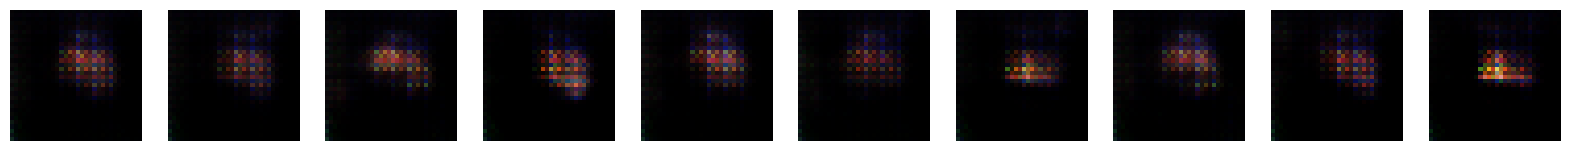

In [31]:
show_gan(50, 2)